In [34]:
# 오늘 실습을 위한 작업디렉토리로 이동합니다.
!cd ~/aiffel/lxmert

from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
sys.path.append(os.getenv('HOME')+'/aiffel/lxmert')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

In [35]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL)

In [36]:
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)

In [37]:
# VQA answer definition
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)

In [38]:
image_path = os.path.join(os.getcwd(),"IMG.jpeg")

In [39]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /aiffel/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [40]:
image_preprocess = Preprocess(frcnn_cfg)
images, sizes, scales_yx = image_preprocess(image_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


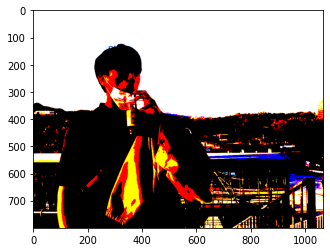

In [41]:
import matplotlib.pyplot  as plt
plt.imshow(images[0].permute(1,2,0))

In [55]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

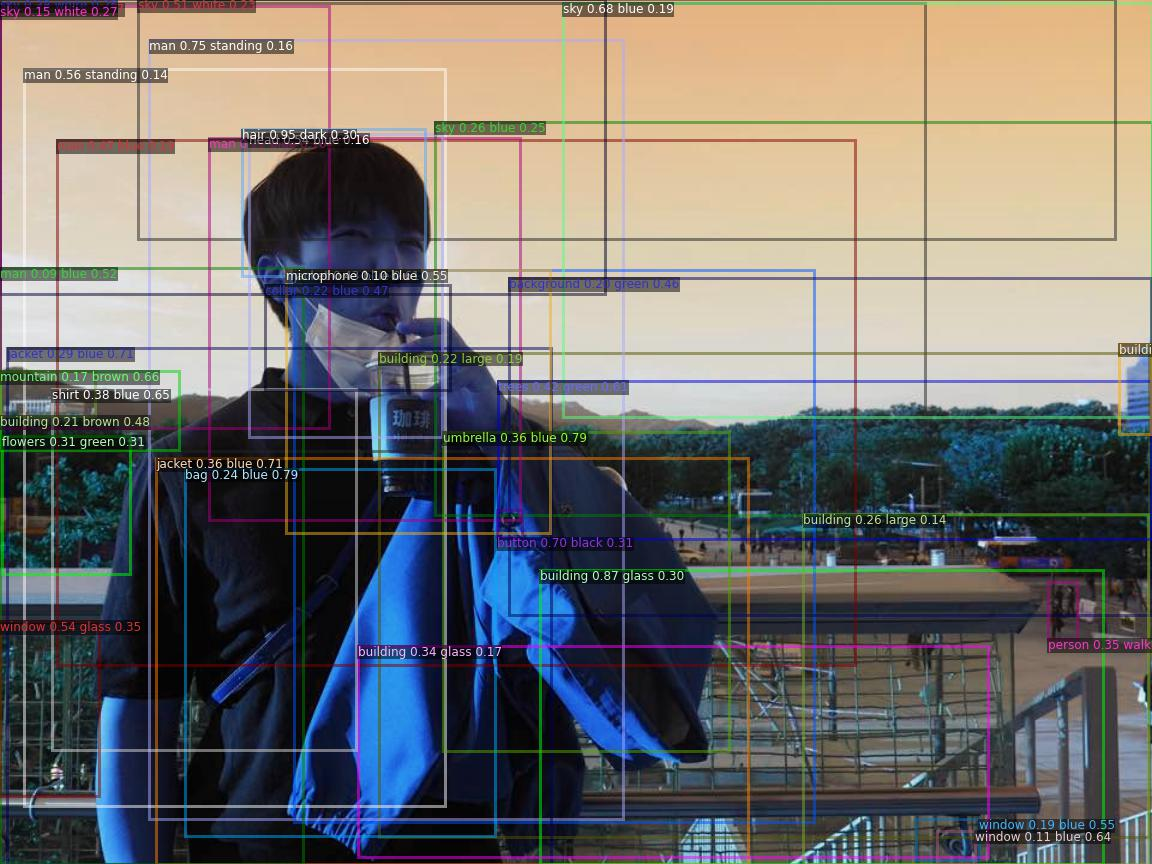

In [57]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    return a

#image viz
frcnn_visualizer = SingleImageViz(image_path, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
img = showarray(frcnn_visualizer._get_buffer())

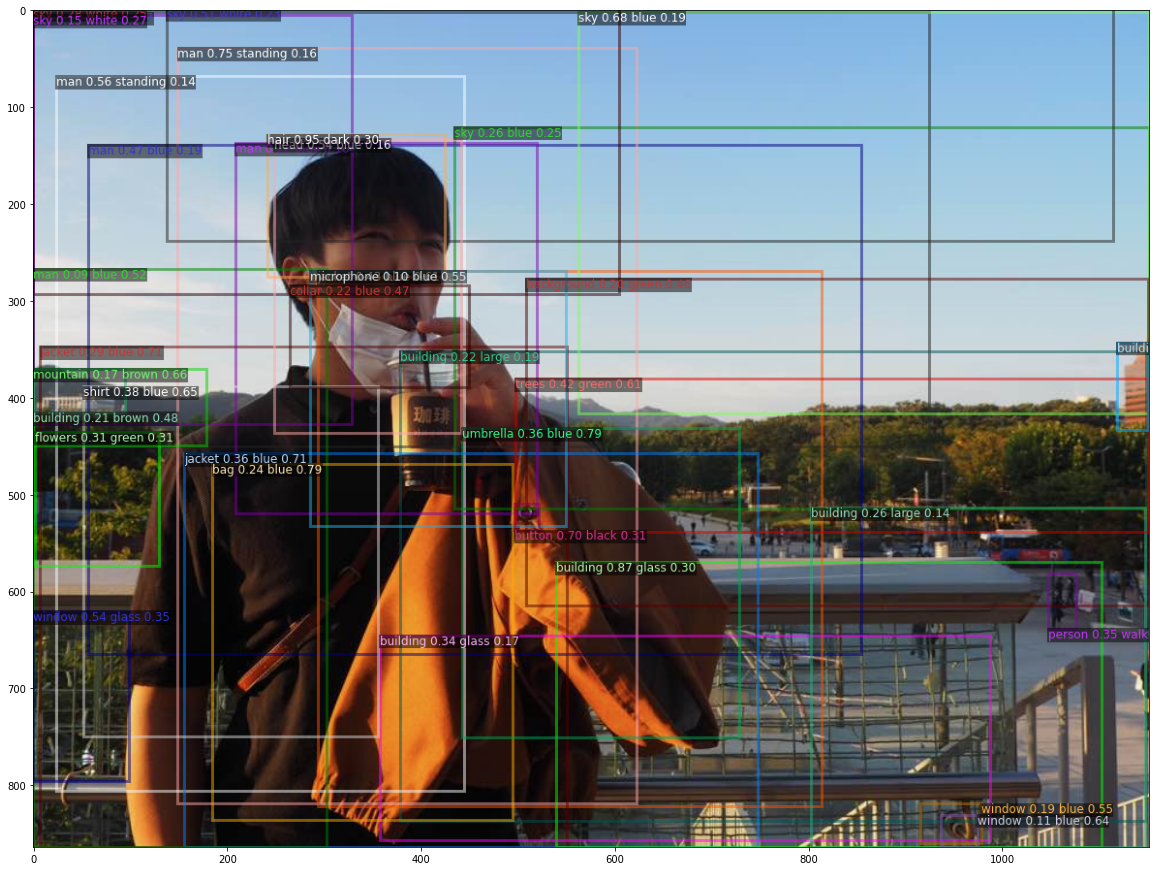

In [68]:
ten_img = torch.tensor(img)
permute = [2,1,0]
plt.figure(figsize=(20,20))
plt.imshow(ten_img[:,:,permute])

In [69]:
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [71]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [73]:
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [89]:
test_questions_for_mine = [
    "Where is this scene?",
    "what is the man drink?",
    "What is the man wearing?",
    "Does he wearing a mask?"
]

inputs = lxmert_tokenizer(
    test_questions_for_mine[2],
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [90]:
output_vqa = lxmert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

In [91]:
pred_vqa = output_vqa["question_answering_score"].argmax(-1)

pred_vqa

tensor([441])

In [92]:
vqa_answers[int(pred_vqa)]

'jacket'

In [93]:
for test_question in test_questions_for_mine:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is this scene?']
prediction from LXMERT VQA: park
Question: ['what is the man drink?']
prediction from LXMERT VQA: water
Question: ['What is the man wearing?']
prediction from LXMERT VQA: jacket
Question: ['Does he wearing a mask?']
prediction from LXMERT VQA: no


---
---
# GQA

In [96]:
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
gqa_answers = utils.get_data(GQA_URL)
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [99]:
for test_question in test_questions_for_mine:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT GQA:", gqa_answers[pred_gqa])

Question: ['Where is this scene?']
prediction from LXMERT GQA: park
Question: ['what is the man drink?']
prediction from LXMERT GQA: soda
Question: ['What is the man wearing?']
prediction from LXMERT GQA: jacket
Question: ['Does he wearing a mask?']
prediction from LXMERT GQA: no
